# CNN Classifier Based Retrieval technique (CCBR)

In [1]:
import sys
sys.path.append('/Users/jinjishen/Desktop/fashion-dataset')
from imports import *

In [2]:
# Custom Dataset Class for Loading Images
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['class_label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# CNN Model Definition Using ResNet50
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

    def extract_features(self, x):
        # Get features before the final classification layer
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

# Function to train the CNN classifier
def train_cnn_classifier(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Evaluation on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Data preparation function
def prepare_data(df, batch_size=32, test_size=0.2):
    le = LabelEncoder()
    df['class_label'] = le.fit_transform(df['masterCategory'])  # Encode masterCategory as class label

    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['class_label'], random_state=42)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = FashionDataset(train_df, transform=transform)
    test_dataset = FashionDataset(test_df, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, le

# Save and Load Model
def save_model(model, file_path='cnn_model.pth'):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

def load_model(file_path, num_classes):
    model = CNNClassifier(num_classes=num_classes)
    model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))
    model.eval()
    print(f"Model loaded from {file_path}")
    return model

# Generate Feature Representations Using the Classifier Model
def extract_features(image_path, model):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_tensor = img_tensor.to(device)
        model = model.to(device)
        with torch.no_grad():
            features = model.extract_features(img_tensor).cpu().numpy().flatten()
        return features / np.linalg.norm(features)
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None

# Feature Generation Function
def generate_features(df, model, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    dataset = FashionDataset(df, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    
    features = []
    labels = []
    paths = []
    with torch.no_grad():
        for images, labels_batch in loader:
            images = images.to(device)
            # Extract features using the model
            batch_features = model.extract_features(images).cpu().numpy()
            features.extend(batch_features)
            labels.extend(labels_batch.numpy())
            paths.extend(df.iloc[labels_batch.numpy()]['path'].values)
    
    return np.array(features), np.array(labels), paths

In [3]:
# Function to retrieve similar images based on cosine similarity
def retrieve_similar_images(input_feature, features, labels, input_label, input_index=None, k=10):
    """
    Retrieve similar images based on the predicted class using cosine similarity.

    Parameters:
    - input_feature (numpy array): Feature vector of the input image.
    - features (numpy array): Feature vectors of all images in the dataset.
    - labels (list): True labels of all images in the dataset.
    - input_label (int): Predicted class label of the input image.
    - input_index (int): Index of the input image in the features array (default: None).
    - k (int): Number of similar images to retrieve (default: 10).

    Returns:
    - List of indices of the top K similar images, excluding the input image.
    """
    # Filter features that belong to the same class as the input image
    same_class_indices = [i for i, label in enumerate(labels) if label == input_label]
    same_class_features = features[same_class_indices]
    
    # Calculate similarities with same-class features
    similarities = cosine_similarity([input_feature], same_class_features)[0]
    
    # Exclude the input image itself if its index is known
    if input_index is not None:
        try:
            # Find the index of the input image within the filtered same_class_features
            input_feature_index_in_same_class = same_class_indices.index(input_index)
            similarities[input_feature_index_in_same_class] = -np.inf  # Exclude by setting similarity to negative infinity
        except ValueError:
            print(f"Input image index {input_index} not found in the same class indices list.")

    # Get the top K similar indices
    top_k_indices_in_same_class = np.argsort(similarities)[-k:][::-1]
    
    # Return the indices relative to the original dataset
    top_k_indices = [same_class_indices[i] for i in top_k_indices_in_same_class]
    return top_k_indices

# Function to plot similar images along with the input image
def plot_similar_images(input_image_path, top_k_indices, df, input_image_id=None):
    """
    Plot the input image along with the top K similar product images and their product IDs.

    Parameters:
    - input_image_path (str): Path to the input image to be displayed.
    - top_k_indices (list): List of indices of the top K similar products.
    - df (pd.DataFrame): DataFrame containing product IDs and image paths.
    - input_image_id (str or int): ID of the input image to be displayed with the input image (optional).
    """
    num_images = len(top_k_indices)
    plt.figure(figsize=(15, 5))

    # Plot input image with ID if provided
    img = Image.open(input_image_path)
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(img)
    title = "Input Image"
    if input_image_id is not None:
        title += f"\nID: {input_image_id}"
    plt.title(title)
    plt.axis('off')

    # Plot similar images
    for i, idx in enumerate(top_k_indices, start=2):
        img_path = df.iloc[idx]['path']
        product_id = df.iloc[idx]['id']
        img = Image.open(img_path)
        plt.subplot(1, num_images + 1, i)
        plt.imshow(img)
        plt.title(f"ID: {product_id}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to visualize t-SNE with true and predicted labels
def visualize_tsne_with_labels(features, true_labels, predicted_labels, title='t-SNE Visualization'):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(16, 8))
    
    # True Labels
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=true_labels,
        palette=sns.color_palette("hsv", len(set(true_labels))),
        legend="full",
        alpha=0.8
    )
    plt.title(f'{title} - True Labels')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))

    # Predicted Labels
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=predicted_labels,
        palette=sns.color_palette("hsv", len(set(predicted_labels))),
        legend="full",
        alpha=0.8
    )
    plt.title(f'{title} - Predicted Labels')
    plt.legend(loc='best', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

# Function to evaluate the CNN classifier
def evaluate_classifier(model, test_loader, label_encoder):
    """
    Evaluate the CNN classifier on the test set and print accuracy and classification report.

    Parameters:
    - model (nn.Module): Trained CNN model.
    - test_loader (DataLoader): DataLoader for the test set.
    - label_encoder (LabelEncoder): Encoder used for labels.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = label_encoder.inverse_transform(all_preds)
    all_labels = label_encoder.inverse_transform(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy:.4f}')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=label_encoder.classes_)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Dataset loaded successfully. Total samples: 4440
Training the CNN model...


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.3344, Accuracy: 66.44%
Epoch [2/5], Loss: 0.1950, Accuracy: 96.85%
Epoch [3/5], Loss: 0.1358, Accuracy: 96.17%
Epoch [4/5], Loss: 0.1155, Accuracy: 95.50%
Epoch [5/5], Loss: 0.1031, Accuracy: 96.17%
Model saved to cnn_model.pth


/var/folders/2x/hs6ytzgj4q5_w36zk_xks7y40000gn/T/ipykernel_53633/3367473625.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path,

Model loaded from cnn_model.pth
Accuracy: 0.9617

Classification Report:
               precision    recall  f1-score   support

  Accessories       0.96      0.91      0.93       225
      Apparel       0.98      0.98      0.98       428
     Footwear       0.99      0.99      0.99       185
   Free Items       0.00      0.00      0.00         2
Personal Care       0.76      1.00      0.86        48

     accuracy                           0.96       888
    macro avg       0.74      0.77      0.75       888
 weighted avg       0.96      0.96      0.96       888



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


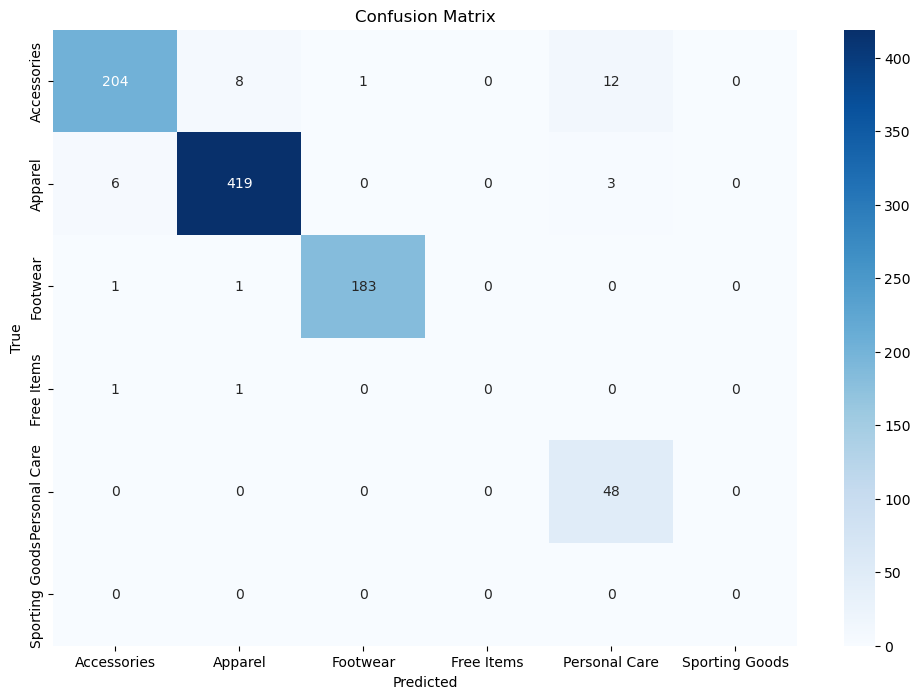

Generating features for the entire dataset...


TypeError: 'bool' object is not callable

In [34]:
# Empty for keeping model training outputs

Dataset loaded successfully. Total samples: 4440
Model already exists at cnn_model.pth. Skipping training.


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/2x/hs6ytzgj4q5_w36zk_xks7y40000gn/T/ipykernel_48130/3367473625.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Model loaded from cnn_model.pth
Generating features for the entire dataset...
Feature generation completed. Shape of features: (4440, 2048)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


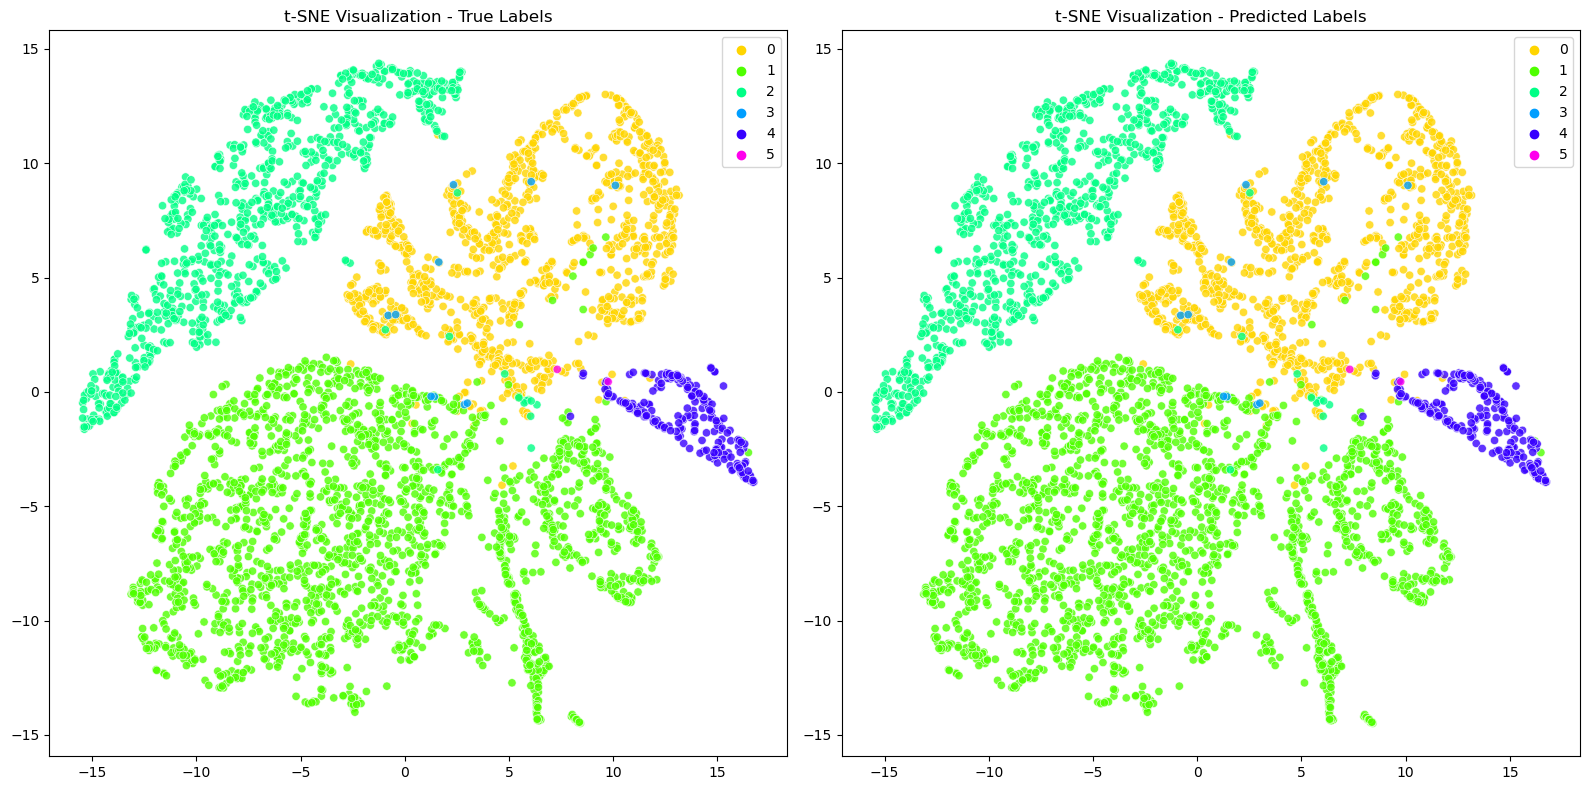

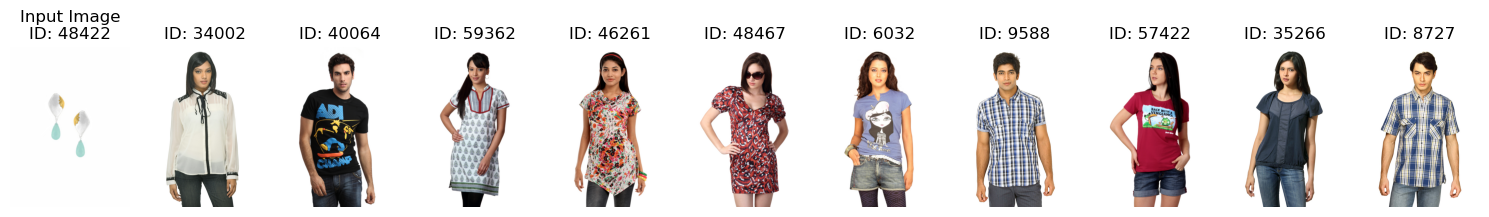

In [4]:
# Enhanced main pipeline with flags for each step
def main_pipeline(df, num_classes, k=10, batch_size=32, num_epochs=5, model_save_path='cnn_model.pth',
                  train_model=False, generate_features_flag=False, evaluate_model=False, visualize_tsne=False):
    # Step 1: Data Preparation
    train_loader, test_loader, label_encoder = prepare_data(df, batch_size=batch_size)
    
    # Step 2: Train and save the model if not already saved and train_model flag is True
    if train_model or not os.path.exists(model_save_path):
        print("Training the CNN model...")
        model = CNNClassifier(num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_cnn_classifier(model, train_loader, test_loader, criterion, optimizer, num_epochs)
        save_model(model, model_save_path)
    else:
        print(f"Model already exists at {model_save_path}. Skipping training.")

    # Step 3: Load the trained model
    model = load_model(model_save_path, num_classes)

    # Step 4: Evaluate the model if evaluate_model flag is True
    if evaluate_model:
        evaluate_classifier(model, test_loader, label_encoder)
    
    # Step 5: Generate features for the entire dataset if generate_features_flag is True
    if generate_features_flag:
        print("Generating features for the entire dataset...")
        features, labels, paths = generate_features(df, model, batch_size=batch_size)
        print(f"Feature generation completed. Shape of features: {features.shape}")
        
        # Save features, labels, and paths for future use
        np.save("features.npy", features)
        np.save("labels.npy", labels)
        np.save("paths.npy", paths)
    else:
        # Load previously saved features, labels, and paths
        features = np.load("features.npy")
        labels = np.load("labels.npy")
        paths = np.load("paths.npy", allow_pickle=True)
        print("Loaded saved features, labels, and paths.")

    # Step 6: Visualize the t-SNE plot if visualize_tsne flag is True
    if visualize_tsne:
        predicted_labels = labels  # Using true labels as predicted labels for visualization purposes
        visualize_tsne_with_labels(features, labels, predicted_labels)

    # Step 7: Perform similarity search on a random sample
    random_idx = np.random.randint(len(features))
    input_image_path = paths[random_idx]
    input_feature = features[random_idx]
    input_label = labels[random_idx]
    input_index = random_idx  # Index of the input image in the dataset

    # Retrieve similar images excluding the input image itself
    top_k_indices = retrieve_similar_images(
        input_feature, 
        features, 
        labels, 
        input_label, 
        input_index=input_index, 
        k=10
    )

    # Visualize the similar images
    plot_similar_images(input_image_path, top_k_indices, df, input_image_id=df.iloc[input_index]['id'])

if __name__ == "__main__":
    # Load dataset
    try:
        sampled_df = pd.read_csv('/Users/jinjishen/Desktop/fashion-dataset/sampled_df.csv')
        sampled_df = sampled_df[sampled_df['id'] != 39410].reset_index(drop=True)  # Remove missing image
        print(f"Dataset loaded successfully. Total samples: {len(sampled_df)}")
    except FileNotFoundError:
        print("The file path specified does not exist. Please check the file path and try again.")
        exit()
    
    # Run the main pipeline with specific flags
    main_pipeline(
        df=sampled_df,
        num_classes=sampled_df['masterCategory'].nunique(),
        k=10,
        batch_size=32,
        num_epochs=5,  # Reduced epochs for quick testing; adjust as necessary
        model_save_path='cnn_model.pth',  # Path to save/load the trained model
        train_model=False,           # Set to True if you want to retrain the model
        generate_features_flag=True,  # Set to True if you want to regenerate features
        evaluate_model=False,        # Set to True if you want to evaluate the model
        visualize_tsne=True         # Set to True if you want to visualize t-SNE
    )